## Case A) LGN 3x3 and V1 3x1

In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
t_train = np.load('t_train.npy')
t_test = np.load('t_test.npy')

n = 28
pat = x_train[0,:].reshape(n,n)/255

def visualize_Hypercolumn(mfr, n, FR):

    titles = [r'Vertical, $\theta=0°$', r'Horizontal, $\theta=90°$', r'ACW from vertical, $\theta=45°$', r'CW from vertical, $\theta=-45°$']
    nL = n**2
    
    for ii in range(4):
        
        a = asarray(mfr[nL*ii : nL*(ii+1)]/FR)
        b = a.reshape(n,n)
        
        plt.subplot(2,2,ii+1)
        plt.imshow(b,cmap='gray')
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])

nL1 = nL2 = n**2
nL3 = nL1*4

[X,Y] = np.meshgrid(range(n), range(n))

taum = 10*ms
taui = 50*ms
taue = 100*ms

dge = 100*mV

duration = 500*ms

eqsPOISSON='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

############################################## Layer 1 ############################################################

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
FR = 100*Hz
L1.rates = pat.flatten()*FR

############################################## Layer 2 ############################################################

L2 = NeuronGroup(nL2,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2.x = X.flatten()
L2.y = Y.flatten()

e1 = Synapses(L1, L2, on_pre='ge += dge')
e1.connect(condition = 'i==j')

i1 = Synapses(L1, L2, on_pre='gi -= 1/8*dge')
i1.connect(condition = 'sqrt((x_pre-x_post)**2+(y_pre-y_post)**2)<2 and i!=j')

############################################## Layer 3 ############################################################

L3 = NeuronGroup(nL3,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3.ori = np.repeat(np.array([0,1,2,3]), nL1)

X3 = np.tile(X.flatten(), (1,4))
X3.flatten()
L3.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,4))
Y3.flatten()
L3.y = Y3.flatten()

cond_range = 'abs(y_pre-y_post)<2 and abs(x_pre-x_post)<2 and ('

cond_ver = 'ori_post==0 and x_pre==x_post or '
cond_hor = 'ori_post==1 and y_pre==y_post or '
cond_CW = 'ori_post==2 and abs(x_pre-x_post+y_pre-y_post)<1 or '
cond_ACW = 'ori_post==3 and abs(x_pre-x_post-y_pre+y_post)<1)'
condV1be = cond_range + cond_ver + cond_hor + cond_CW + cond_ACW

cond_ver = 'ori_post==0 and x_pre!=x_post or '
cond_hor = 'ori_post==1 and y_pre!=y_post or '
cond_CW = 'ori_post==2 and abs(-x_pre+x_post+y_pre-y_post)>=1 or '
cond_ACW = 'ori_post==3 and abs(x_pre-x_post+y_pre-y_post)>=1)'
condV1bi = cond_range + cond_ver + cond_hor + cond_CW + cond_ACW

e2 = Synapses(L2, L3, on_pre='ge += 1/3*dge')
e2.connect(condition = condV1be)

i2 = Synapses(L2, L3, on_pre='gi -= 1/6*dge')
i2.connect(condition = condV1bi)

###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

sp1 = SpikeMonitor(L1)
sp2 = SpikeMonitor(L2)
sp3 = SpikeMonitor(L3)
run(duration)
MFR1 = sp1.count/duration
MFR2 = sp2.count/duration
MFR3 = sp3.count/duration

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Text(0.5, 1.0, 'LGN')

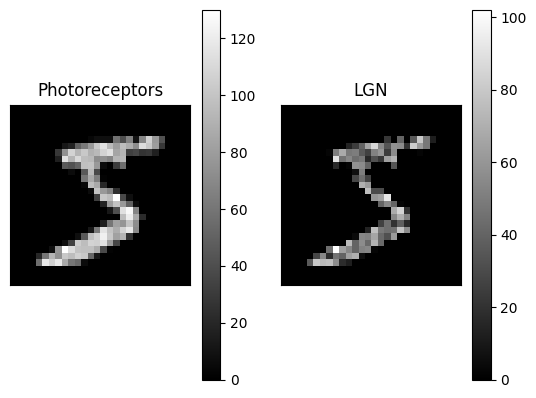

In [24]:
subplot(121)
tmp = asarray(MFR1)
tmp = tmp.reshape(n,n)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Photoreceptors')

subplot(122)
tmp = asarray(MFR2)
tmp = tmp.reshape(n,n)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('LGN')

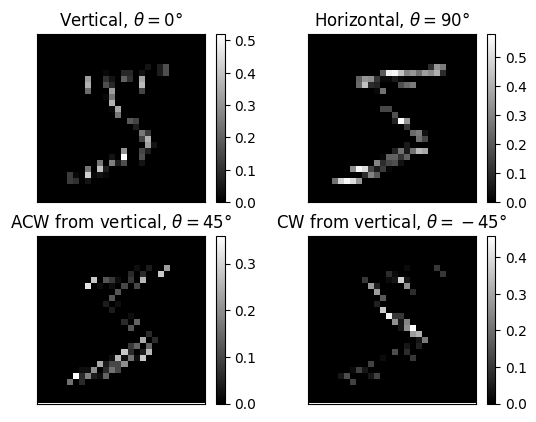

In [25]:
visualize_Hypercolumn(MFR3,n,FR)

## Case B) LGN 6x6 and V1 3x1

Text(0.5, 1.0, 'LGN')

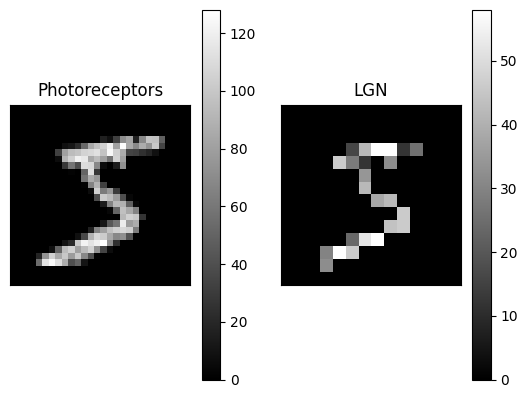

In [5]:
subplot(121)
tmp = asarray(MFR1)
tmp = tmp.reshape(n,n)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Photoreceptors')

subplot(122)
tmp = asarray(MFR2)
tmp = tmp.reshape(nb,nb)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('LGN')

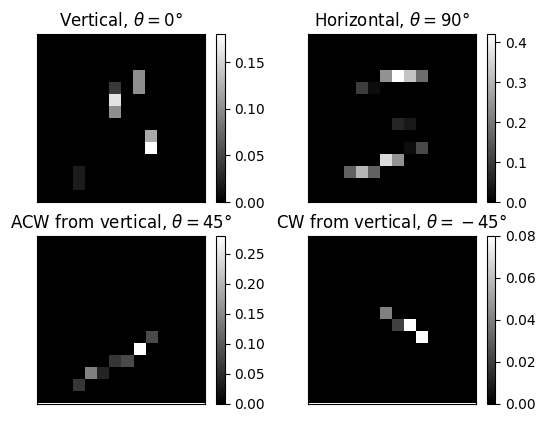

In [6]:
visualize_Hypercolumn(MFR3,nb,FR)

## Case C) LGN 12x12 and V1 3x1

Text(0.5, 1.0, 'LGN')

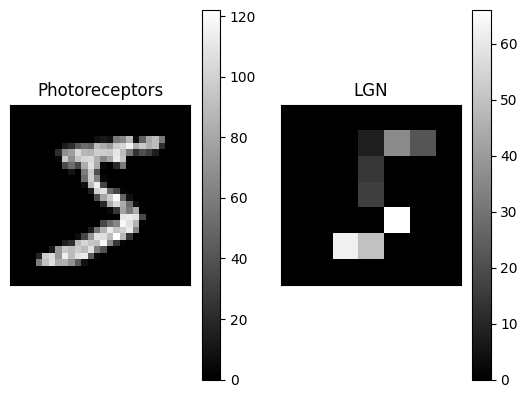

In [2]:
subplot(121)
tmp = asarray(MFR1)
tmp = tmp.reshape(n,n)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Photoreceptors')

subplot(122)
tmp = asarray(MFR2)
tmp = tmp.reshape(nb,nb)
plt.imshow(tmp,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('LGN')

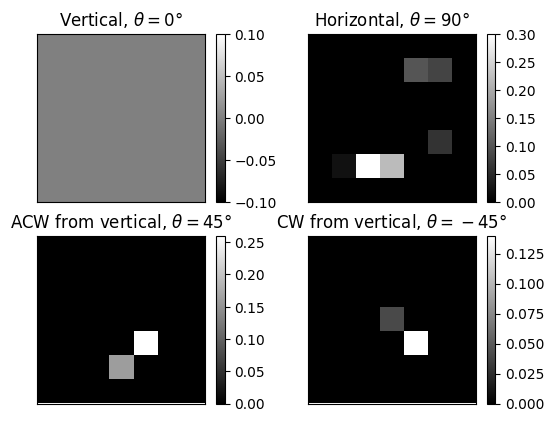

In [3]:
visualize_Hypercolumn(MFR3,nb,FR)